In [29]:
## TORCH LIBRARY
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import torchio as tio

## MONAI LIBRARY
from monai.networks.nets import BasicUNet
from monai.networks.nets import VNet
from monai.networks.nets import UNet
from monai.losses.dice import DiceLoss
from monai.handlers import checkpoint_saver

## OTHER LIBRARIES
import argparse
import logging
import sys
import numpy as np
from pathlib import Path
import os
import itertools
import matplotlib.pyplot as plt
from dicom_contour.contour import *
from functools import reduce
import SimpleITK as sk
import pydicom as pyd
import copy
import itk
from numpy import savez_compressed
from numpy import load

## WEIDGHTS & BIASES
import wandb
os.environ["WANDB_CONFIG_DIR"] = "/tmp"
from tqdm import tqdm

## IMPORT OTHER CLASSES
import import_ipynb
import DosePredictionDataset

## IGNORE WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [40]:
## MAIN TRAINING FUNCTION
def train(device:str,
          npz_pathlist_patients:list,
          epochs:list,
          learning_rate:list,
          dropout_rate:list,
          batch_size:list,
          ROI_names:list,
          val_percent: float = 0.4,
          ):
    ## Create dataloaders for training and validation
    dataset = DosePredictionDataset.DosePrdictionDataset(npz_pathlist_patients)
    val_num = int(len(dataset) * val_percent)
    train_num = len(dataset) - val_num
    train_set, val_set = random_split(dataset, [train_num, val_num], generator=torch.Generator().manual_seed(42)) 
    # Login wandb account
    wandb.login() 
    # Create combinations of hyperparameters
    param_combinations = list(itertools.product(epochs, batch_size, dropout_rate, learning_rate))
    # Create a variable to store the best model and path to store to
    best_val_loss = float('inf')
    best_model = None
    best_param = None
    model_save_path = "/Users/wangyangwu/Documents/Maastro/NeuralNets/BasicUNet/saved_model/"
    net = None
    ### ================================== TRAINING START ===================================== ###
    print("TRAINING STARTS ...")
    for comb in param_combinations:
        # Initiate and configure wandb runner
        run = wandb.init(reinit=True, project="Maastro")
        #Create neural network model
        net = BasicUNet(spatial_dims=3,
                 in_channels=len(ROI_names)+1, 
                 out_channels=2, 
                 features=(2, 2, 4, 8, 16, 2),
                 dropout=comb[2])
        # net = UNet(spatial_dims=3,
        #            in_channels=len(ROI_names)+1, 
        #            out_channels=1,
        #            channels=(1, 2, 4, 8, 16),
        #            strides=(1,1,1,1))
        run.config.update({"epoch":comb[0],
                           "batch_size":comb[1],
                           "dropout_rate":comb[2],
                           "learning_rate":comb[3],
                           "Input":str(ROI_names),
                           "Model":net.__class__.__name__})
        wandb.watch(net, log='all', log_freq=1)
        train_loader = DataLoader(train_set, shuffle=True, batch_size=run.config.batch_size)
        val_loader = DataLoader(val_set, shuffle=False, drop_last=True, batch_size=run.config.batch_size)
        # Set up optimizer
        optimizer = torch.optim.Adam(net.parameters(), lr=run.config.learning_rate) 
        # Create step counter
        sample_count = 0 
        cross_entropy_loss = nn.CrossEntropyLoss()
        for epoch in tqdm(range(run.config.epoch)):
            # Create epoch loss log variables
            epoch_loss_train = 0
            epoch_loss_val = 0  
            ## ========================== TRAINING SECTION =========================== ##
            net.train()
            for images, masks in train_loader:
                images = images.to(device=device, dtype=torch.float32)
                masks = masks.to(device=device, dtype=torch.float32)
                # forward pass
                image_pred = net(images)
                train_loss = DiceLoss().forward(normalize(image_pred), masks)
                epoch_loss_train += train_loss.item()
                # backword pass
                optimizer.zero_grad()
                train_loss.backward()
                # optimizing
                optimizer.step()
                sample_count += len(images)
                # Log training loss
                wandb.log({"training_loss": train_loss.item(),
                           "epoch":epoch+1},
                          step=sample_count)
            print(f"Training loss after epoch {epoch+1}: {epoch_loss_train*run.config.batch_size/train_num}")                
            ## ========================== VALIDATION SECTION ========================== ##
            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(device=device, dtype=torch.float32)
                    masks = masks.to(device=device, dtype=torch.float32)
                    image_pred = net(images)
                    val_loss = DiceLoss().forward(normalize(image_pred), masks)
                    epoch_loss_val += val_loss.item()
                    wandb.log({"validation_loss": val_loss.item(),
                               "epoch":epoch+1},
                              step=sample_count)
            print(f"Validation loss after epoch {epoch+1}: {epoch_loss_val}")
            if best_val_loss >= epoch_loss_val:
                best_val_loss = epoch_loss_val
                best_model = copy.deepcopy(net)  
                best_param = comb
        run.finish()
    print("TRAINING FINISHED")
    print("Best validation loss is: ", best_val_loss)
    best_param = {'epoch':best_param[0],
                  'batch_size':best_param[1],
                  'dropout_rate':best_param[2],
                  'learning_rate':comb[3]}
    torch.save({'model_state_dict': best_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'param': best_param,
                'loss': best_val_loss}, model_save_path+f"{net.__class__.__name__}_{ROI_names}.pt")

In [41]:
## PREPROCESS DATA INCLUDING ORIGIN ALIGNMENT AND CROPPING
def process_patients_data(patient_path_list:list, ROI_names:list):
    CT_paths = []
    dose_paths = []
    plan_paths = []
    sizes = []
    INPUTs = []
    DOSEs = []
    PLANs = []
    for patient_path in patient_path_list:
        subfolder_path = []
        for roots, dirs, files in os.walk(patient_path):
            subfolder_path.append(roots)
        CT_paths += [input_path for input_path in subfolder_path if "/CT/" in input_path]
        dose_paths += [input_path for input_path in subfolder_path if "/RTDOSE/" in input_path]
        plan_paths += [input_path for input_path in subfolder_path if "/RTPLAN/" in input_path]

    for CT_path ,dose_path, plan_path in zip(CT_paths, dose_paths, plan_paths):
        
        # ============================== get images, origins and spacing ============================ #
        #Get CT scan, origin, and spacing
        CT = get_CT_image(CT_path)
        CT_origin = np.array(list(CT.GetOrigin()))[::-1]
        CT_spacing = np.array(CT.GetSpacing())[::-1]
        
        #Get Dose map, origin, spacing and GridScaling
        DOSE = get_RTDose_image(dose_path)
        DOSE_origin = np.array(list(DOSE.GetOrigin()))[::-1]
        DOSE_spacing = np.array(DOSE.GetSpacing())[::-1]
        DOSE_GridScaling = float(DOSE.GetMetaData('3004|000e'))
        
        #Get RT plan map
        xCTspace, yCTspace, zCTspace, x_ct, y_ct, z_ct = get_image_info(CT)
        mask_3d = get_struct_contours(CT_path, ["CTV1"])
        mask_3d_ctv = mask_3d[0]
        RTPLAN = get_RTPlan_image(plan_path, xCTspace, yCTspace, zCTspace, x_ct, y_ct, z_ct, mask_3d_ctv)

        #Get CT array
        CT = sk.GetArrayFromImage(CT)
        
        #define slicing based on origin
        origin_difference = list(map(lambda x,y: x-y if(x-y>=0) else 0, DOSE_origin, CT_origin))
        slicing_idx = (origin_difference/CT_spacing).astype(int)
        
        # ======================= align CT scan origin with Dose ======================= # 
        aligned_CT = CT[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:]
        # fig, ax = plt.subplots(2,3,figsize=(30, 10))
        # ax[0][0].imshow(aligned_CT[50])
        # ax[0][1].imshow(aligned_CT[:,80,:])
        # ax[0][2].imshow(aligned_CT[:,:,150])
        
        # ======================= align Struct contour origin with Dose ======================= #        
        struct_contours = get_struct_contours(CT_path, ROI_names)
        aligned_struct_contours = [contour[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:] for contour in struct_contours]
        
        # ======================= align RT plan origin with Dose ======================= #        
        aligned_plan = RTPLAN[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:]
    
        # ========================== get X slicing from body contour ========================== #   
        body_contour = get_struct_contours(CT_path, ["Body1"])[0] 
        lung_contour = get_struct_contours(CT_path, ["Lungs-GTV"])[0]
        aligned_body_contour = body_contour[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:]
        aligned_lung_contour = lung_contour[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:]
        X_slicing_idx = aligned_lung_contour.shape[0]-1
        Y_slicing_idx = aligned_body_contour.shape[1]-1
        Z_slicing_idx = aligned_body_contour.shape[2]-1
        X_slicing_idx = min(list(map(lambda x:x-1 if(np.mean(aligned_lung_contour[x])==0 and np.mean(aligned_lung_contour[x-1])>0) else 10000, range(X_slicing_idx,0,-1))))
        Y_slicing_idx = min(list(map(lambda y:y-1 if(np.mean(aligned_body_contour[:,y,:])==0 and np.mean(aligned_body_contour[:,y-1,:])>0) else 10000, range(Y_slicing_idx,0,-1))))
        Z_slicing_idx = min(list(map(lambda z:z-1 if(np.mean(aligned_body_contour[:,:,z])==0 and np.mean(aligned_body_contour[:,:,z-1])>0) else 10000, range(Z_slicing_idx,0,-1))))        
        
        # ==================================== final slicing  ==================================#   
        aligned_CT = aligned_CT[:X_slicing_idx, :Y_slicing_idx, :Z_slicing_idx]
        aligned_plan = aligned_plan[:X_slicing_idx, :Y_slicing_idx, :Z_slicing_idx]
        # ax[1][0].imshow(aligned_CT[50,:,:])
        # ax[1][1].imshow(aligned_CT[:,50,:])
        # ax[1][2].imshow(aligned_CT[:,:,150])
        aligned_struct_contours = [contour[:X_slicing_idx,:Y_slicing_idx,:Z_slicing_idx] for contour in aligned_struct_contours]
        aligned_struct_contours.append(aligned_CT)
        resampled_CT_contour = resample(torch.from_numpy(np.stack(aligned_struct_contours)).type(torch.float32), DOSE_spacing/CT_spacing)
        resampled_plan = resample(torch.from_numpy(np.stack([aligned_plan])).type(torch.float32), DOSE_spacing/CT_spacing)
        dose_map = np.stack([sk.GetArrayFromImage(DOSE)*DOSE_GridScaling])
        INPUTs.append(resampled_CT_contour)
        DOSEs.append(dose_map)
        PLANs.append(resampled_plan)
        
        # =============================== add size to size list  ===============================# 
        x = max(resampled_CT_contour.shape[1], dose_map.shape[1])
        y = max(resampled_CT_contour.shape[2], dose_map.shape[2])
        z = max(resampled_CT_contour.shape[3], dose_map.shape[3])
        sizes.append((x,y,z)) 
           
    X = max([t[0] for t in sizes])
    Y = max([t[1] for t in sizes])
    Z = max([t[2] for t in sizes])
    max_outdim = (X,Y,Z)
    print(f"Best input size is: {max_outdim}")
    
    patients_data = []
    for inputs, dose, plan in zip(INPUTs, DOSEs, PLANs):
        patients_data.append([pad(inputs,max_outdim), 
                              np.concatenate((pad(dose,max_outdim,True), pad(plan,max_outdim,True)))])   
    return patients_data

##### ==================================   FUNCTIONS FOR READ DICOME   ================================

In [7]:
## GET STRUCTURE CONTOURS FROM FILES
def get_struct_contours(path:str, ROI_names:list):
    contours_list = []
    #store dicom file
    contour_file = get_contour_file(path)
    contour_data = dicom.read_file(path + '/' + contour_file)
    ROI_list = get_roi_names(contour_data)
    # print(ROI_list)
    target_ROI_index = []
    for name in ROI_names:
        for t in ROI_list:
            if name.lower()=="body1" and t.lower()=="body":   
                target_ROI_index.append(ROI_list.index(t))
            elif name.lower()=="lungs-gtv" and t.lower()=="lungs-gtv1":
                target_ROI_index.append(ROI_list.index(t))
            elif name.lower()==t.lower():
                target_ROI_index.append(ROI_list.index(t))
                
    # images, contours = get_data(path, index=target_ROI_index[0])
    for index in target_ROI_index:
        images, contours = get_data(path, index=index)
        #get contour maps
        contour_slices = [contours[i] for i in range(contours.shape[0])]
        contour_3d = [fill_contour(c) if c.max()==1 else c for c in contour_slices]
        contour_3d = np.stack(contour_3d)
        contours_list.append(contour_3d)
    return contours_list

In [8]:
## READ CT DICOM SERIES
def get_CT_image(folder_path:str):
    path = Path(folder_path)
    file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(path))
    file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path), file_ids[0])
    series_reader = sk.ImageSeriesReader()
    series_reader.SetFileNames(file_names)
    image_data = series_reader.Execute()
    return image_data   

In [9]:
## READ RTDOSE
def get_RTDose_image(dose_path):   
    dose_file_path = [os.path.join(dose_path, f) for f in os.listdir(dose_path)][0]
    file_reader = sk.ImageFileReader()
    file_reader.SetFileName(dose_file_path)
    dose_image = file_reader.Execute()
    return dose_image

In [32]:
def get_RTPlan_image(plan_path, xCTspace, yCTspace, zCTspace, x_ct, y_ct, z_ct, mask_3d):
    plan_file_path = [os.path.join(plan_path, f) for f in os.listdir(plan_path)][0]
    #read and convert plan
    plan = pyd.read_file(plan_file_path)
    
    bs = plan.IonBeamSequence
    
    beam_array = np.zeros(mask_3d.shape)
    
    for beam in bs:
        beam_para = beam.IonControlPointSequence[0]
        isocenter = beam_para.IsocenterPosition
        gantry =  float(beam_para.GantryAngle)
        couch = float(beam_para.PatientSupportAngle)
        
        #find isocenter position in the image space
        x_iso = int(round(abs(x_ct - isocenter[0])/xCTspace, 0))
        y_iso = -int(round(abs(y_ct - isocenter[1])/yCTspace, 0))
        z_iso = int(round(abs(z_ct - isocenter[2])/zCTspace, 0))
        
        #position of image points
        contour_x = np.where(mask_3d == True)[2] - x_iso
        contour_y = -np.where(mask_3d == True)[1] - y_iso
        contour_z = np.where(mask_3d == True)[0] - z_iso
        
        
        #couch = 190
        if couch == 270:
            couch = 0
        elif couch == 0:
            couch = -90
        else:
            couch = 270 - couch
        couch_rad = np.pi * couch /180.
        
        #gantry = 90
        if 355 <= gantry <= 360:
            gantry = 360 - gantry + 180
        elif 180 <= gantry <= 185:
            gantry = 180 - gantry
        else:
            gantry = np.abs(gantry -180) #-180 angle 0, -135 gantry 45
        gantry_rad = np.pi * gantry /180.
        
    
        rotation_matrix = np.array([[np.cos(couch_rad), 0, np.sin(couch_rad)],
                                    [np.sin(gantry_rad)*np.sin(couch_rad), np.cos(gantry_rad), -np.sin(gantry_rad)*np.cos(couch_rad)],
                                    [-np.cos(gantry_rad)*np.sin(couch_rad), np.sin(gantry_rad), np.cos(couch_rad)*np.cos(gantry_rad)]])
        
    
        p_x_iso = np.sum(np.array([x_iso, y_iso, z_iso]) * rotation_matrix[0])
        p_y_iso = np.sum(np.array([x_iso, y_iso, z_iso]) * rotation_matrix[1])
        p_z_iso = np.sum(np.array([x_iso, y_iso, z_iso]) * rotation_matrix[2])
        
        lim_x =[]
        lim_y =[]
        lim_z=[]
        for p in np.arange(len(contour_x)):
            point = np.array([contour_x[p], contour_y[p], contour_z[p]])
            lim_x.append(int(round(np.sum(point * rotation_matrix[0]) + p_x_iso, 0)))
            lim_y.append(int(round(np.sum(point * rotation_matrix[1]) + p_y_iso, 0)))
            lim_z.append(int(round(np.sum(point * rotation_matrix[2]) + p_z_iso, 0)))
        
        shift_x = np.min(lim_x)
        shift_y = np.min(lim_y)
        shift_z = np.min(lim_z) 
    
        center_shift = 100 #to avoid matrix being cut
        
        p_mask_3d = np.zeros((512, 512, 512)) # make this size bigger to capture full path
        for p in np.arange(len(lim_x)):
            p_x = lim_x[p] - shift_x + center_shift
            p_y = lim_y[p] - shift_y + center_shift
            p_z = lim_z[p] - shift_z + center_shift
            p_mask_3d[p_z, p_y, p_x] = 1
            
    
        
        p_beam = np.zeros((512, 512, 512))
        for d1 in np.arange(512, dtype = np.int64):
            for d2 in np.arange(512, dtype = np.int64):
                if np.sum(p_mask_3d[d1, :, d2]) != 0:
                    depth = np.max(np.where(p_mask_3d[d1, :, d2] == True)[0])
                    p_beam[d1, : depth, d2] = 1 
                    
        p_contour_x = np.where(p_beam == 1)[2] + shift_x - p_x_iso - center_shift
        p_contour_y = np.where(p_beam == 1)[1] + shift_y - p_y_iso - center_shift
        p_contour_z = np.where(p_beam == 1)[0] + shift_z - p_z_iso - center_shift 
        
        reverse_rotation_matrix = rotation_matrix.T
        
        pp_x_iso = np.sum(np.array([p_x_iso, p_y_iso, p_z_iso]) * reverse_rotation_matrix[0])
        pp_y_iso = np.sum(np.array([p_x_iso, p_y_iso, p_z_iso]) * reverse_rotation_matrix[1])
        pp_z_iso = np.sum(np.array([p_x_iso, p_y_iso, p_z_iso]) * reverse_rotation_matrix[2])
        
        
        for p in np.arange(len(p_contour_x)):
            point = np.array([p_contour_x[p], p_contour_y[p], p_contour_z[p]])
            x = int(round(np.sum(point * reverse_rotation_matrix[0]) + pp_x_iso, 0))
            y = -int(round(np.sum(point * reverse_rotation_matrix[1]) + pp_y_iso, 0)) 
            z = int(round(np.sum(point * reverse_rotation_matrix[2]) + pp_z_iso, 0))
            if y>= beam_array.shape[1] or x>= beam_array.shape[2] or z>= beam_array.shape[0] or y<= -beam_array.shape[1] or x<= -beam_array.shape[2] or z<= -beam_array.shape[0]:
                pass
            else:
                beam_array[z, y, x] = 1
                    
    beam_array[np.where(beam_array>0)] = 1
    
    pp_y_iso = -1*pp_y_iso
         
    return beam_array

In [11]:
def get_image_info(image):
    xCTspace = image.GetSpacing()[0]
    yCTspace = image.GetSpacing()[1]
    zCTspace = image.GetSpacing()[2]
    x_ct = image.GetOrigin()[0]  # x image corner
    y_ct = image.GetOrigin()[1]  # y image corner
    z_ct = image.GetOrigin()[2] # z image corner
    
    return xCTspace, yCTspace, zCTspace, x_ct, y_ct, z_ct

##### ==============================  FUNCTIONS FOR PROCESSING IMAGES  ============================

In [12]:
## CROP INPUT IMAGES
def pad(images:object, out_dim:tuple, if_dose:bool=False):
    X_fin = out_dim[0] - images.shape[1]
    Y_fin = out_dim[1] - images.shape[2]
    Z_fin = out_dim[2] - images.shape[3]
    if if_dose:
        padding = 0
        padder = tio.Pad((0,X_fin,0,Y_fin,0,Z_fin), padding_mode=padding)
        padded = padder(images)
    else:
        chunks = torch.chunk(images, images.shape[0], 0)
        CT_padder = tio.Pad((0,X_fin,0,Y_fin,0,Z_fin), padding_mode=-1024)
        Contour_padder = tio.Pad((0,X_fin,0,Y_fin,0,Z_fin), padding_mode=0)
        chunks = torch.chunk(images, images.shape[0], 0)
        padded = CT_padder(chunks[images.shape[0]-1])
        for chunk in chunks[:images.shape[0]-1]:
            padded = torch.cat((padded, Contour_padder(chunk)))
        print(padded.shape)
    return padded

In [13]:
## RESAMPLE DOSE IMAGES
def resample(dose_map:object, spacing:tuple, if_dose:bool=False):
    resampler = tio.Resample(spacing)
    resampled = resampler(dose_map)
    return resampled

In [14]:
## NORMALIZE TENSOR
def normalize(inputs:torch.TensorType):
    return (inputs-inputs.min())/(inputs.max()-inputs.min())

##### ==================================  FUNCTIONS FOR SAVING FILES  ================================

In [15]:
## SAVE PROCESSED DATA TO COMPRESSED NPY FORMAT
def save_to_npz(patient_inputs:list, patient_IDs:list, ROI_names:list):
    save_dir = "/Users/wangyangwu/Documents/Maastro/NeuralNets/Processed_data/preprocessed_data_compressed_npz"+str(ROI_names)
    os.makedirs(save_dir, exist_ok=True)
    for patient, ID in zip(patient_inputs, patient_IDs):
        sub_save_dir = save_dir+"/"+ID+"/"
        os.makedirs(sub_save_dir,exist_ok=True)
        save_path_inputs = os.path.join(sub_save_dir, "inputs.npz")
        save_path_label = os.path.join(sub_save_dir, "label.npz")
        inputs = patient[0].numpy()
        label = patient[1]
        savez_compressed(save_path_inputs, inputs)
        savez_compressed(save_path_label, label)       

##### ============================  FUNCTIONS FOR GETTING PATIENTS LIST/ID  ==========================

In [16]:
## GET PATH LIST FOR ALL PATIENTS 
def get_patient_list(top_dir:str):
    pathlist_patients = []
    for folder in os.listdir(top_dir):
        folder_path = os.path.join(top_dir, folder)
        if os.path.isdir(folder_path):
            pathlist_patients.append(folder_path)
    return pathlist_patients

In [17]:
## GET LIST OF PATIENT ID
def get_patient_IDs(patient_dirs:list):
    patient_IDs = [patient.split('/')[-1] for patient in patient_dirs]
    return patient_IDs

##### ==================================  FUNCTIONS FOR TRAINING  ================================

In [18]:
def process(top_dir:str, ROI_names:list):
    ## get patient dirs and patient IDs
    pathlist_patients = get_patient_list(top_dir)
    patients_IDs = get_patient_IDs(pathlist_patients)
    ## get processed patient data
    patients_data = process_patients_data(pathlist_patients, ROI_names)
    ## save processed data to compressed npz files
    save_to_npz(patients_data, patients_IDs, ROI_names)
    return patients_data

In [58]:
def visualize_data(patients_data:list, slice_idx1:int, slice_idx2:int, slice_idx3:int):
    ## visualize processed data
    fig, ax = plt.subplots(3,4,figsize=(30, 10))
    ax[0][0].imshow(patients_data[0][0][0][slice_idx1])
    ax[0][0].set(xlabel="CT scan (Axial)")
    ax[0][1].imshow(patients_data[0][0][1][slice_idx1])
    ax[0][1].set(xlabel="contour (Axial)")
    ax[0][2].imshow(patients_data[0][1][0][slice_idx1])
    ax[0][2].set(xlabel="Dose map (Axial)")
    ax[0][3].imshow(patients_data[0][1][1][slice_idx1])
    ax[0][3].set(xlabel="Plan map (Axial)")
    
    ax[1][0].imshow(patients_data[0][0][0][:,slice_idx2,:])
    ax[1][0].set(xlabel="CT scan (Cronal)")
    ax[1][1].imshow(patients_data[0][0][1][:,slice_idx2,:])
    ax[1][1].set(xlabel="contour (Cronal)")
    ax[1][2].imshow(patients_data[0][1][0][:,slice_idx2,:])
    ax[1][2].set(xlabel="Dose map (Cronal)")
    ax[1][3].imshow(patients_data[0][1][1][:,slice_idx2,:])
    ax[1][3].set(xlabel="Plan map (Cronal)")
    
    ax[2][0].imshow(patients_data[0][0][0][:,:,slice_idx3])
    ax[2][0].set(xlabel="CT scan (Saggital)")
    ax[2][1].imshow(patients_data[0][0][1][:,:,slice_idx3])
    ax[2][1].set(xlabel="contour (Saggital)")
    ax[2][2].imshow(patients_data[0][1][0][:,:,slice_idx3])
    ax[2][2].set(xlabel="Dose map (Saggital)")
    ax[2][3].imshow(patients_data[0][1][1][:,:,slice_idx3])
    ax[2][3].set(xlabel="Plan map (Saggital)")
    
    # fig.tight_layout(pad=3.0)
    plt.subplots_adjust(bottom=-0.5)

In [23]:
## define parameters
ROI_names = ["CTV1"] 
top_dir = "/Users/wangyangwu/Documents/Maastro/NeuralNets/sample"
npz_dir = "/Users/wangyangwu/Documents/Maastro/NeuralNets/Processed_data/preprocessed_data_compressed_npz"+str(ROI_names)
dropout_rate = [0.5]
learning_rate = [0.1]
epochs = [10]
batch_size = [1]

In [37]:
patients_data = process(top_dir, ROI_names)

(159, 512, 544)
(189, 512, 512)
(166, 512, 586)
Best input size is: (117, 110, 191)
torch.Size([2, 117, 110, 191])
torch.Size([2, 117, 110, 191])
torch.Size([2, 117, 110, 191])


In [42]:
npz_pathlist_patients = get_patient_list(npz_dir)

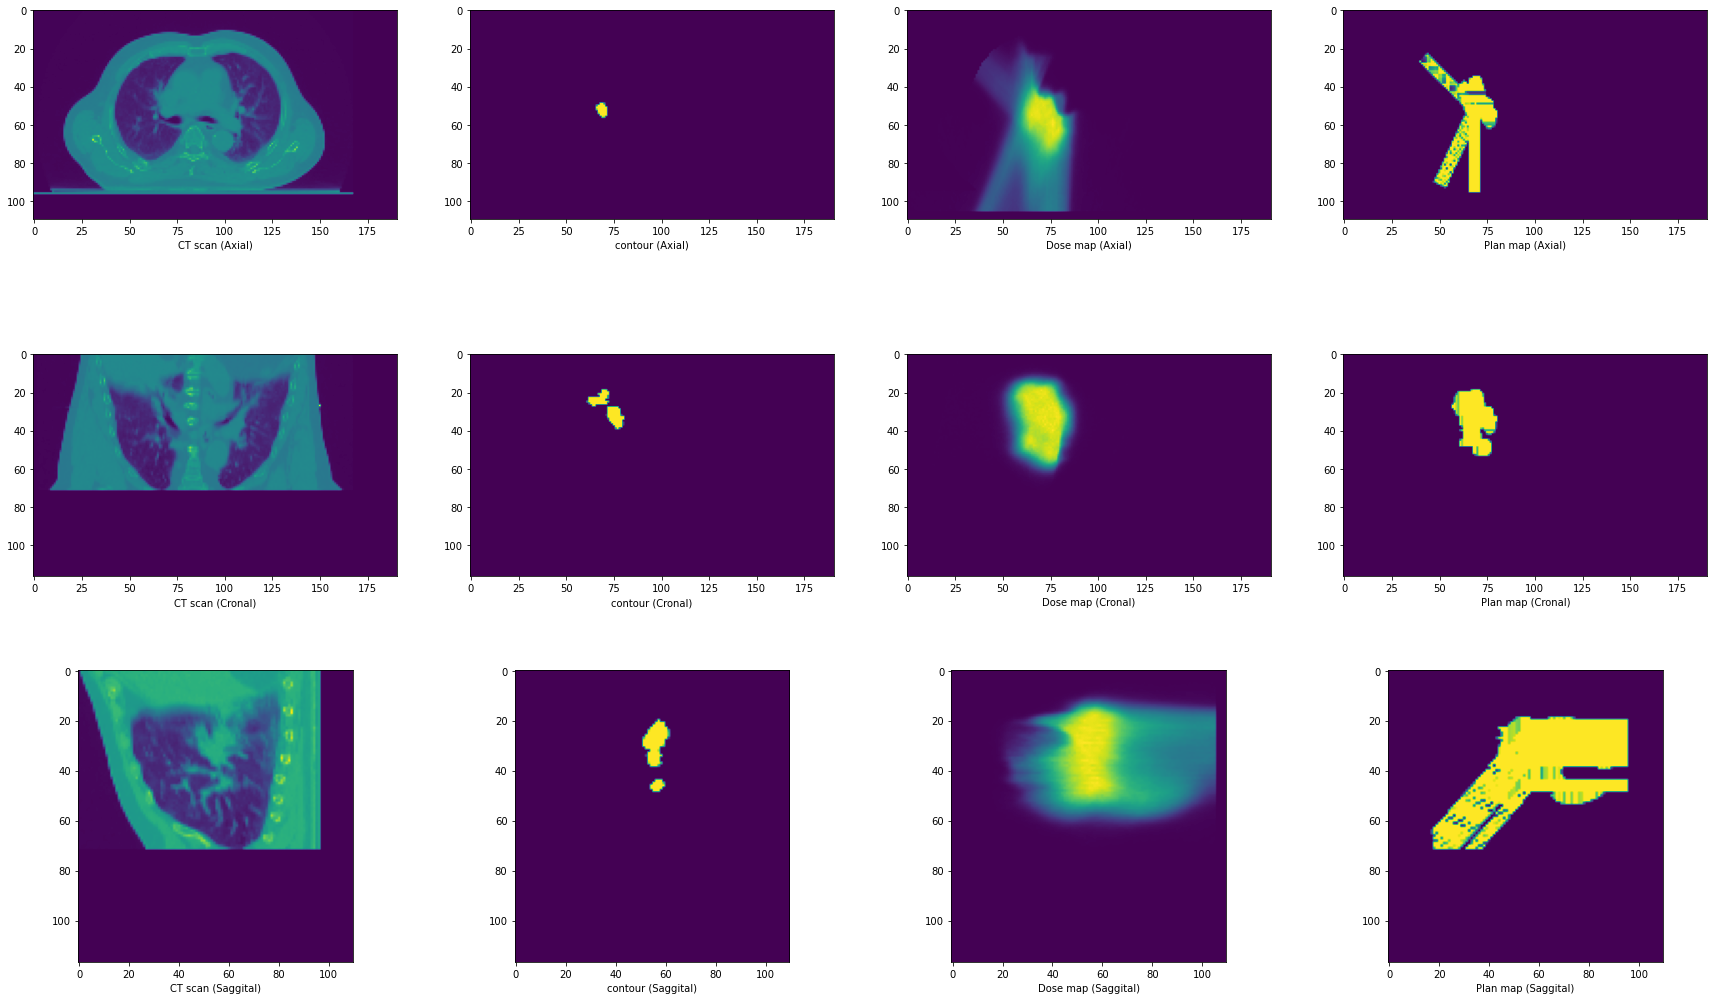

In [59]:
visualize_data(patients_data, 40,60,65)

In [43]:
train("cpu", 
      npz_pathlist_patients, 
      epochs, 
      learning_rate, 
      dropout_rate, 
      batch_size, 
      ROI_names) 

wandb: Currently logged in as: wwy (use `wandb login --relogin` to force relogin)


TRAINING STARTS ...


BasicUNet features: (2, 2, 4, 8, 16, 2).


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Training loss after epoch 1: 0.9770357608795166


 10%|████▍                                       | 1/10 [00:09<01:23,  9.29s/it]

Validation loss after epoch 1: 0.982132613658905
Training loss after epoch 2: 0.976118415594101


 20%|████████▊                                   | 2/10 [00:16<01:05,  8.16s/it]

Validation loss after epoch 2: 0.9814609289169312
Training loss after epoch 3: 0.9740850925445557


 30%|█████████████▏                              | 3/10 [00:24<00:54,  7.81s/it]

Validation loss after epoch 3: 0.9782009720802307
Training loss after epoch 4: 0.970727950334549


 40%|█████████████████▌                          | 4/10 [00:31<00:46,  7.76s/it]

Validation loss after epoch 4: 0.9793193340301514
Training loss after epoch 5: 0.971470832824707


 50%|██████████████████████                      | 5/10 [00:39<00:38,  7.70s/it]

Validation loss after epoch 5: 0.9775679111480713
Training loss after epoch 6: 0.9703695774078369


 60%|██████████████████████████▍                 | 6/10 [00:46<00:30,  7.61s/it]

Validation loss after epoch 6: 0.9785879850387573
Training loss after epoch 7: 0.9705694317817688


 70%|██████████████████████████████▊             | 7/10 [00:54<00:22,  7.63s/it]

Validation loss after epoch 7: 0.9786767959594727
Training loss after epoch 8: 0.9705630540847778


 80%|███████████████████████████████████▏        | 8/10 [01:01<00:15,  7.59s/it]

Validation loss after epoch 8: 0.979178786277771
Training loss after epoch 9: 0.971224308013916


 90%|███████████████████████████████████████▌    | 9/10 [01:09<00:07,  7.59s/it]

Validation loss after epoch 9: 0.9773274660110474
Training loss after epoch 10: 0.9700048565864563


100%|███████████████████████████████████████████| 10/10 [01:17<00:00,  7.73s/it]

Validation loss after epoch 10: 0.9779138565063477


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
training_loss,█▃▃█▃▇▁▇▂▇▇▁▁▇▇▁▁▇▁▇
validation_loss,█▇▂▄▁▃▃▄▁▂
epoch,10
training_loss,0.98086
validation_loss,0.97791


TRAINING FINISHED
Best validation loss is:  0.9773274660110474
